In [1]:
import logging
logger = logging.getLogger('retrain_contract_uber_model')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.info('logging started')

2020-06-28 00:32:11,510 - retrain_contract_uber_model - INFO - logging started


In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: True


In [3]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [4]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

     |████████████████████████████████| 1.5MB 3.4MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
pip 20.1.1 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)
  Cloning https://www.github.com/nemoware/analyser.git (to revision uber-models) to /tmp/pip-req-build-bmjeqkn_
  Running command git clone -q https://www.github.com/nemoware/analyser.git /tmp/pip-req-build-bmjeqkn_
  Running command git checkout -b uber-models --track origin/uber-models
  Switched to a new branch 'uber-models'
  Branch 'uber-models' set up to track remote branch 'uber-models' from 'origin'.
  Created wheel for nemoware-analyzer: filename=nemoware_analyzer-1.21.2-py3-none-any.whl size=15155550 sha256=3b2887c6948a14f0094dacdb3b5692e2be2fb15736b9163a5a00d11ea4cce41b
  Stored in directory: /tmp/pip-ephem-wheel-cache-iix78gvh/wheels/17/e7/bb/9ae6fe5cb3d92b92f5b6039eb7097d74c7986adb10832367c7
Successfully built nemoware-analyzer
ERROR: ne

In [5]:

if not IN_COLAB:
  import analyser.hyperparams  
  _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
  work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)
  
  if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

  analyser.hyperparams.work_dir = work_dir
else:
  import analyser.hyperparams
  from google.colab import drive
  drive.mount('/content/drive')
  os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
  analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v1.21.2
USING WORKDIR: [/usr/local/lib/python3.6/dist-packages/work]
 set ENV GPN_WORK_DIR to override


/usr/local/lib/python3.6/dist-packages/analyser/hyperparams.py:14: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
work_dir= /content/drive/My Drive/GazpromOil/trainsets/uber_2


# Imports

In [6]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *
# from tensorflow_docs import plots

import random

import pickle
import numpy as np
import pandas as pd
from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector
import math

import os
from os import path
from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
 

from trainsets.retrain_contract_uber_model import DbJsonDoc, UberModelTrainsetManager
from tf_support.super_contract_model import get_base_model


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from IPython.display import SVG
from keras.models import load_model
import warnings

from tensorflow import keras
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences

from tf_support.tools import KerasTrainingContext


import keras.backend as K



1.15.2


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


loading word cases stats model from: /usr/local/lib/python3.6/dist-packages/analyser/vocab/word_cases_stats.pickle


# Prepare trainset


In [7]:
umtm = UberModelTrainsetManager ( analyser.hyperparams.work_dir)

if not IN_COLAB:
  umtm.import_recent_contracts()
  umtm.calculate_samples_weights()
  umtm.validate_trainset()

TOTAL DATAPOINTS IN TRAINSET: 594


In [8]:
umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
umtm.stats

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


,export_date,subject,org-1-alias,org-2-alias,checksum,version,analyze_date,value,value_log1p,value_span,subject confidence,user_correction_date,valid,subject_weight,sample_weight
_id,,,,,,,,,,,,,,,
5eea279dc28b75807f3dacce,2020-06-26 15:08:46.359462,Loans,Заемщик,Займодавец,a2fd74d33e546dc0fde7ae1d50eb3cae,1.20.0,2020-06-18 20:26:19.609000+00:00,6.040500e+10,24.824338,148.0,0.997801,2020-06-17 15:44:57.491000+00:00,True,4.398444,2.565956
5eea279dc28b75807f3daccb,2020-06-26 15:08:44.161431,Loans,Займодавец,Заемщик,839bd7f3a1a443ffdf00c200788df8b3,1.20.0,2020-06-18 20:25:14.243000+00:00,2.215000e+09,21.518518,159.0,0.973850,2020-06-17 15:45:57.928000+00:00,True,3.812710,2.224252
5eea27b1c28b75807f3daec7,2020-06-26 15:12:02.840170,GeneralContract,Заказчик,Подрядчик,571145b01a3a2e2ac7f486d3f73a1b19,1.20.0,2020-06-19 18:46:02.512000+00:00,1.789183e+09,21.305025,4826.0,0.388674,2020-06-19 10:23:11.225000+00:00,True,2.507977,2.202184
5dfa6a938d25a1ac83160bf1,2020-06-26 14:57:06.876423,Service,Заказчик,Исполнитель,e10d3bc6db3c286eddbbbc9107850830,1.11.2,2020-06-12 21:20:30.568000+00:00,1.770000e+09,21.294245,9482.0,0.984551,2020-06-06 11:44:17.759000+00:00,True,1.444043,2.201070
5eea27a9c28b75807f3dade2,2020-06-26 15:09:47.111245,GeneralContract,ЗАКАЗЧИК,ПОДРЯДЧИК,10c564092c2014bdcb294c13d4e1d670,1.20.0,2020-06-18 23:12:32.528000+00:00,1.077877e+09,20.798260,2184.0,0.886859,2020-06-17 20:19:02.229000+00:00,True,2.448322,2.149803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5edbc662da3678279fbcaee3,2020-06-26 15:02:07.193742,Service,Владелец Лицензии,Оператор,e4a73074aa926fad45a8d2d4eec06619,1.11.5,2020-06-16 11:23:18.643000+00:00,NaN,NaN,NaN,0.999367,NaT,True,0.088974,0.135618
5edbc65fda3678279fbcae91,2020-06-26 15:01:36.503495,Service,Владелец Лицензии,Оператор,de8d0defd01d62a35e971d556f18037d,1.11.5,2020-06-16 11:19:38.025000+00:00,NaN,NaN,NaN,0.998887,NaT,True,0.088974,0.135618
5edbc65dda3678279fbcae68,2020-06-26 15:01:21.885414,Service,Заказчик,,e6050d7bfaa96e7a8b283c36c4490687,1.11.5,2020-06-16 11:18:03.345000+00:00,NaN,NaN,NaN,0.999537,NaT,True,0.088974,0.135618


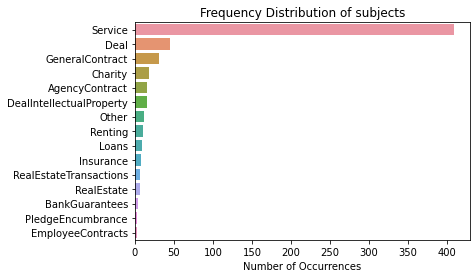


min 2
max 409
total 593


In [9]:
%matplotlib inline

subj_count = umtm.stats['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [10]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = umtm.stats['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(umtm.stats, 'subject')
class_weights

classes: ['Loans', 'GeneralContract', 'Service', 'BankGuarantees', 'Insurance', 'AgencyContract', 'RealEstateTransactions', 'Renting', 'Charity', 'PledgeEncumbrance', 'Deal', 'RealEstate', 'DealIntellectualProperty', 'Other', 'EmployeeContracts']


Service                     0.359515
Deal                        0.564927
GeneralContract             0.624081
Charity                     0.734572
AgencyContract              0.763409
DealIntellectualProperty    0.780102
Other                       0.843253
Renting                     0.902000
Loans                       0.939336
Insurance                   0.984379
RealEstateTransactions      1.111512
RealEstate                  1.111512
BankGuarantees              1.343886
PledgeEncumbrance           1.968758
EmployeeContracts           1.968758
Name: subject, dtype: float64

TOTAL DATAPOINTS IN TRAINSET: 594
docs in meta: 594
docs in meta after drop_duplicates: 594


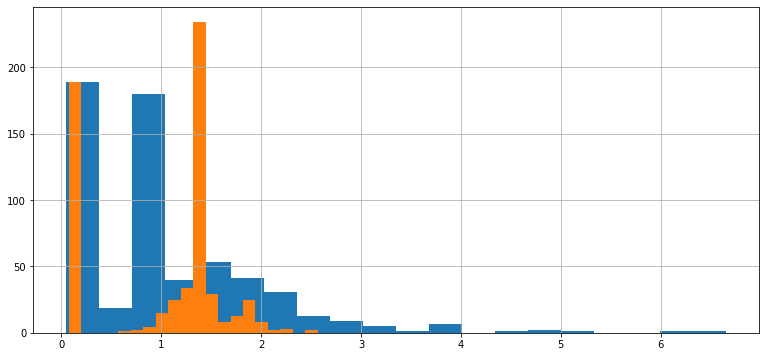

In [11]:
from trainsets.trainset_tools import get_feature_log_weights

def calculate_samples_weights(self):
  # TODO: sync with github!
  self.stats: DataFrame = self.load_contract_trainset_meta()
  subject_weights = get_feature_log_weights(self.stats, 'subject')
  
  value_median = self.stats.value_log1p.median()

  for i, row in self.stats.iterrows():
    subj_name = row['subject']

    tagging_weight = 1.0
    if not pd.isna(row['user_correction_date']):  # MORE weight for user-corrected datapoints
      tagging_weight = 10.0  # TODO: must be estimated anyhow smartly

    value_weight = value_median
    if not pd.isna(row['value_log1p']):
      # вес пропорционален логорифму цены контракта,
      # чтобы было меньше ошибок в контрактах на большие суммы)
      value_weight = row['value_log1p']

    tagging_weight *= value_weight
    subject_weight = tagging_weight * class_weights[subj_name]
    self.stats.at[i, 'subject_weight'] = subject_weight
    self.stats.at[i, 'sample_weight']  = tagging_weight

  # normalize weights, so the sum == Number of samples
  self.stats.sample_weight /= self.stats.sample_weight.mean()
  self.stats.subject_weight /= self.stats.subject_weight.mean()

  self._save_stats()

calculate_samples_weights(umtm)

plt.figure(figsize=(13, 6))

umtm.stats['subject_weight'].hist(bins=20)
umtm.stats['sample_weight'].hist(bins=20)

plt.xscale('linear') # log?
plt.show()

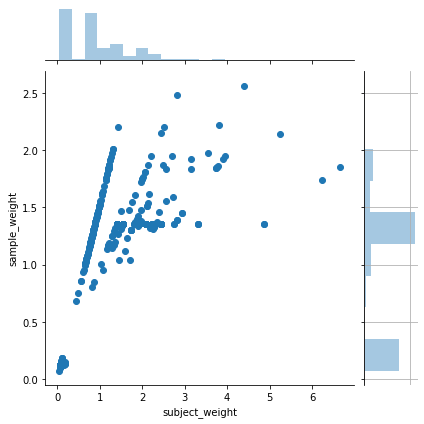

In [12]:
sns.jointplot(x="subject_weight", y="sample_weight", data=umtm.stats )
plt.grid()
plt.show()


### look into trainset

In [13]:
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = umtm.stats.index[0]
print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
dp = umtm.make_xyw(SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
 

SAMPLE_DOC_ID 5eea279dc28b75807f3dacce


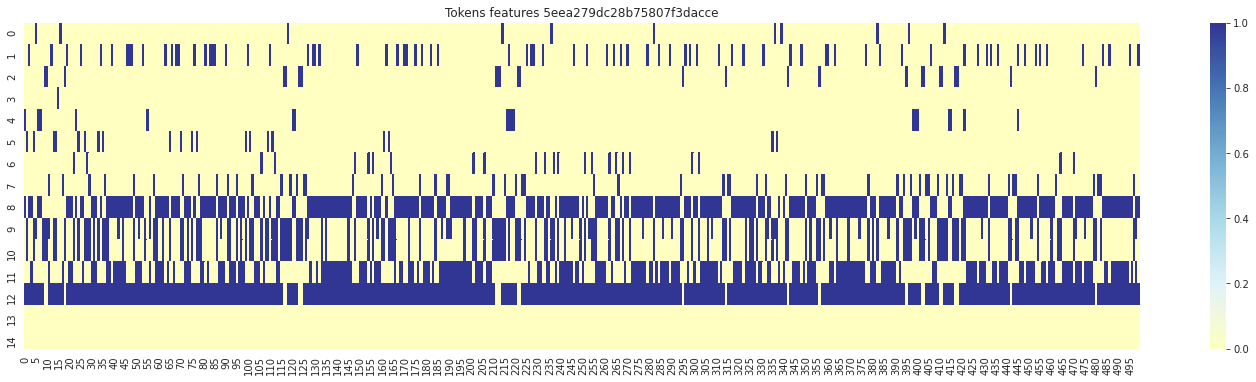

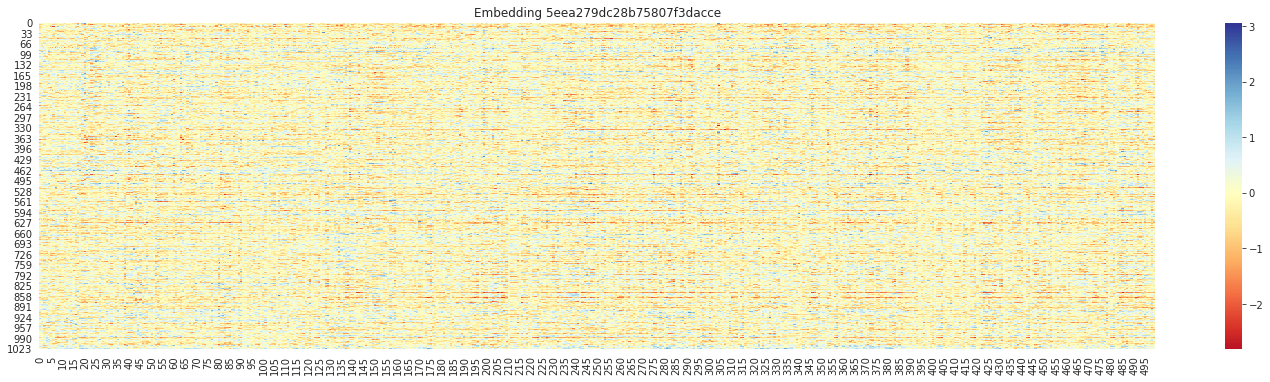

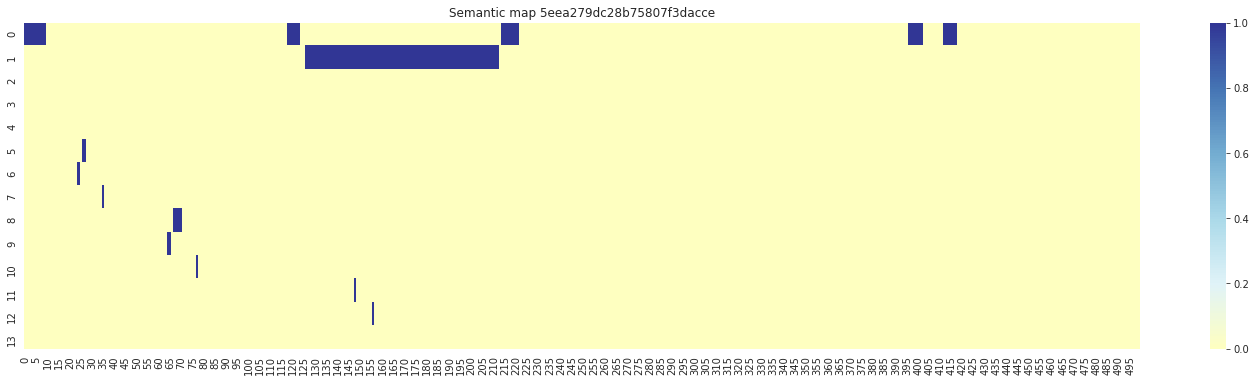

In [14]:
%matplotlib inline

plot_embedding(tok_f[:500], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:500], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:500], title=f'Semantic map {SAMPLE_DOC_ID}')

## Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq

In [15]:
def make_generator(self, indices: [int], batch_size: int, augment_samples=False):

  np.random.seed(42)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 128 * 12
    start_from = 0

    if augment_samples:
      max_len =  random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = self.make_xyw(doc_id)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

      subject_weight_K=1.0
      if augment_samples:
        start_from = 0
        
        row = self.stats.loc[doc_id]
        if random.randint(1, 2) == 1:  # 50% of samples
          segment_center = random.randint(0, len(emb)-1) ##select random token as a center
          if not pd.isna(row['value_span']) and random.random()<0.7:        
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1 #lower subject weight because there mighе be no information about subject around doc. value

      dp = self.trim_maxlen(dp, start_from, max_len)
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Return a tuple of (input, output, weights) to feed the network
    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
            [np.array(batch_output_sm), np.array(batch_output_subj)],
            [np.array(weights), np.array(weights_subj)])

train_indices[0]: 5edbadd3da3678279fbcaa95
test_indices[0]: 5ded4e294ddc27bcf92dd6d4
X: 2 X[0]= (24, 1285, 1024) X[1]= (24, 1285, 15)
Y: 2 Y[0]= (24, 1285, 14) Y[1]= (24, 43)


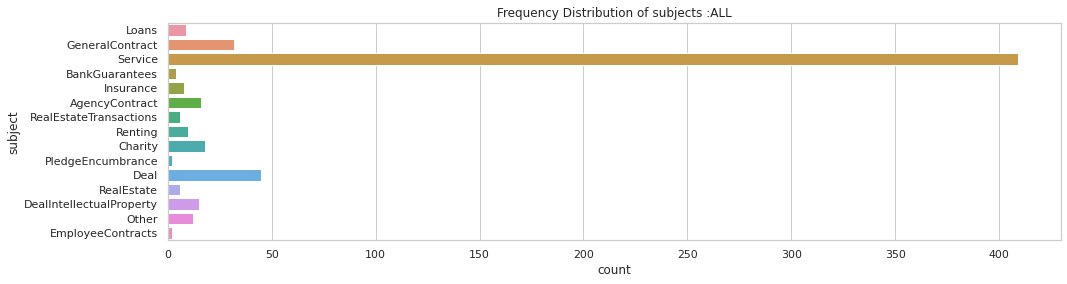

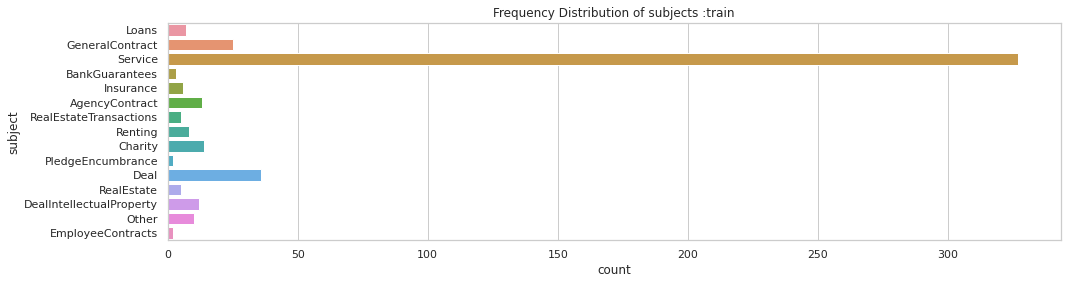

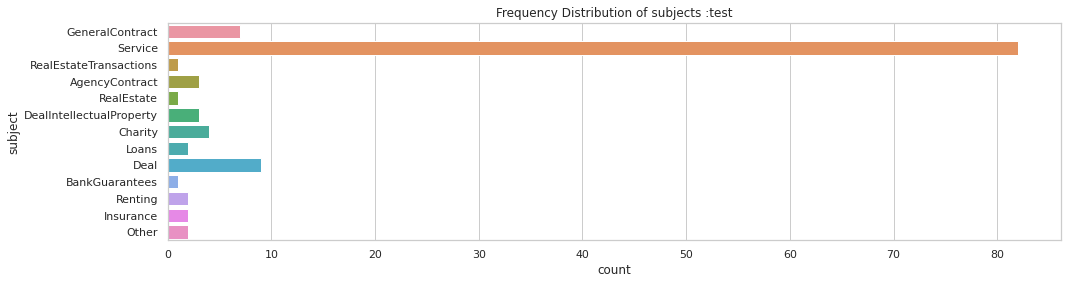

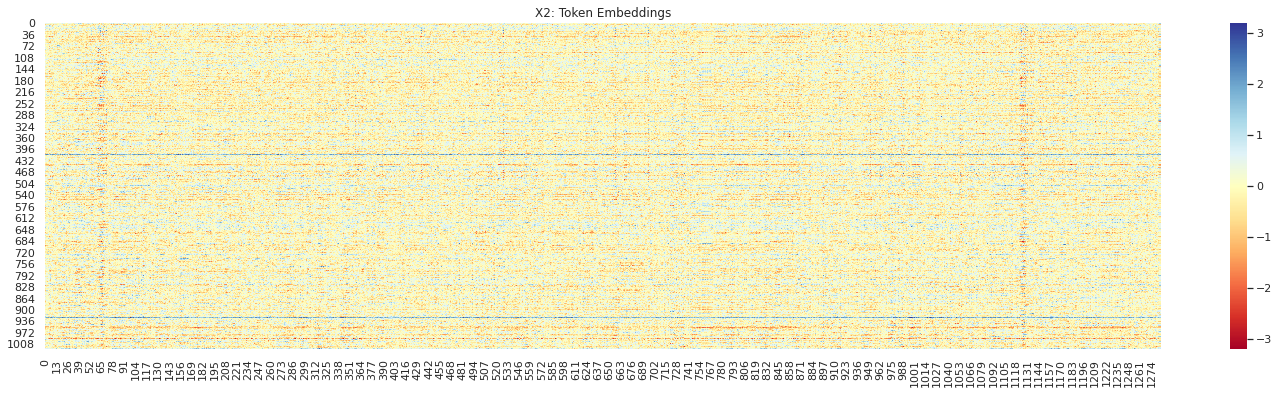

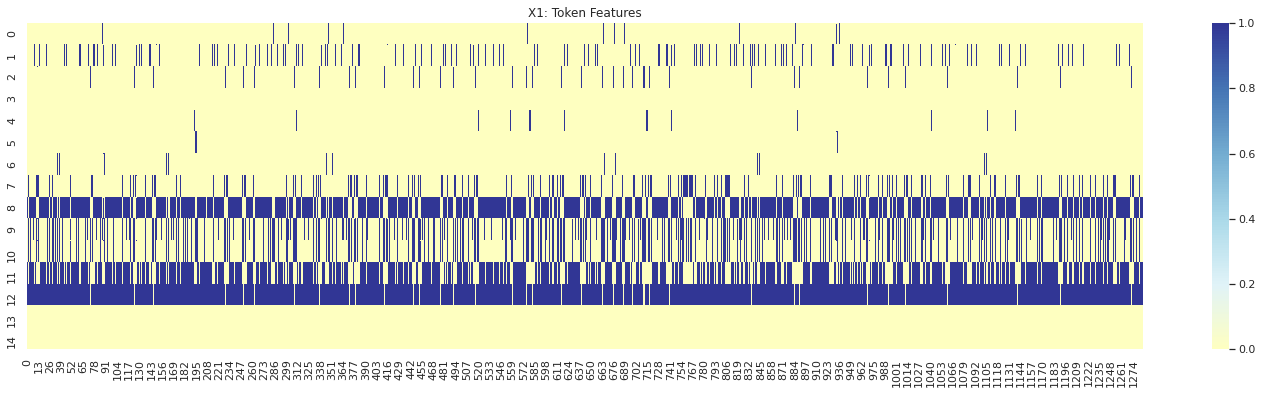

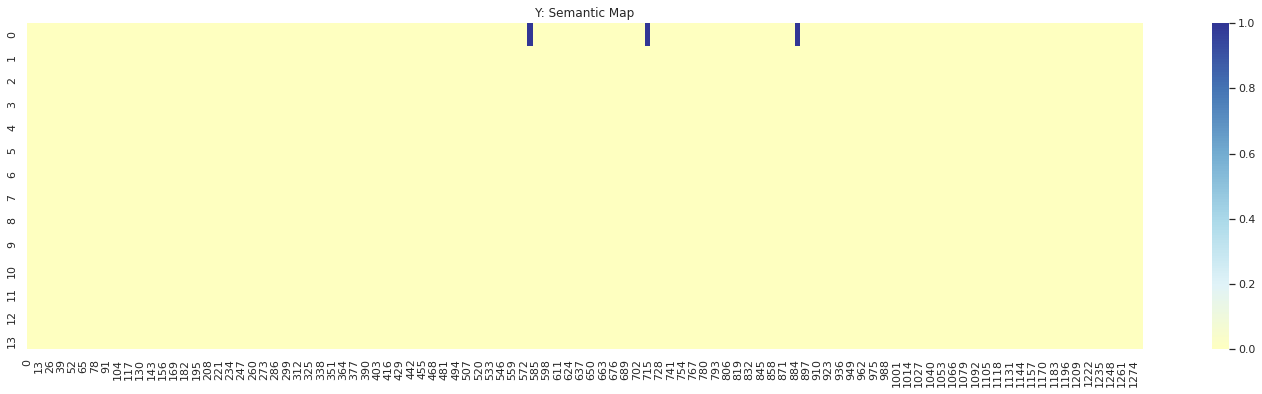

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:
EPOCHS = 50
BATCH_SIZE = 24
EMB =  1024
 
_SELFTEST = True


_train, _test = train_test_split(umtm.stats, test_size=0.2, stratify=umtm.stats[['subject']])
train_indices = list(_train.index)
test_indices = list(_test.index)


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(umtm.stats, 'ALL')
plot_subject_distr(umtm.stats[umtm.stats.index.isin(train_indices)], 'train')
plot_subject_distr(umtm.stats[umtm.stats.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
  print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
  print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

  plot_embedding(x[0][0], 'X2: Token Embeddings')
  plot_embedding(x[1][0], 'X1: Token Features')
  plot_embedding(y[0][0], 'Y: Semantic Map')
  
  print(y[0][1])

  # del x 5edbc665da3678279fbcaf1c
  del y
  del train_gen

In [17]:

ctx = KerasTrainingContext(umtm.work_dir, session_index=21)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']



def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


batch_size:	24
train_samples:	1900
test_samples:	119
steps_per_epoch:	79
validation_steps:	39


In [18]:
from analyser.hyperparams import models_path
from tf_support import super_contract_model


def init_model(model_fn) -> (Model, KerasTrainingContext):
  model_name = model_fn.__name__
  model = model_fn(name=model_name, ctx=ctx, trained=True)
  model.name = model_name

  weights_file_old = os.path.join(models_path, model_name + ".weights")
  weights_file_new = os.path.join(umtm.work_dir, model_name + ".weights")

  try:
    model.load_weights(weights_file_new, by_name=True )
    logger.info(f'weights loaded: {weights_file_new}')

  except:
    msg = f'cannot load  {model_name} from  {weights_file_new}'
    warnings.warn(msg)
    logger.warning(msg)
    model.load_weights(weights_file_old, by_name=True )
    logger.info(f'weights loaded: {weights_file_old}')

  # freeze bottom 6 layers, including 'embedding_reduced' #TODO: this must be model-specific parameter
  for l in model.layers[0:6]:
    l.trainable = False

  model.compile(loss=super_contract_model.losses, optimizer='Nadam', metrics=super_contract_model.metrics)
  model.summary()

  return model




# Models 🦖

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [ ]:
from tf_support.super_contract_model import uber_detection_model_005_1_1


umodel = init_model(uber_detection_model_005_1_1)

######################
# Phase I retraining
# ❄️ frozen bottom layers
######################
test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

ctx.EPOCHS = 25
ctx.EVALUATE_ONLY = False
ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



2020-06-28 00:35:19,004 - retrain_contract_uber_model - INFO - weights loaded: /content/drive/My Drive/GazpromOil/trainsets/uber_2/uber_detection_model_005_1_1.weights


Model: "uber_detection_model_005_1_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     (None, None, 1024)   0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer (None, None, 15)     0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 1039)   0           drops[0][0]                      
                                                                 input_

In [ ]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
ctx.unfreezeModel(umodel)
umodel.compile(loss=super_contract_model.losses, optimizer='Nadam', metrics=super_contract_model.metrics)
umodel.summary()

ctx.EPOCHS *= 2

test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
 
ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

# Evaluate models

### training history

In [ ]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.work_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid()
        plt.title(f'{metric}')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{m} {title}')
        plt.grid()
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        plt.savefig(img_path, bbox_inches='tight')
        plt.grid()
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')

## Contract subj Confusion matrices

In [ ]:
from tf_support.tf_subject_model import decode_subj_prediction


def plot_cm(y_true, y_pred, figsize=(12, 12), title=None):
  cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
  cm_sum = np.sum(cm, axis=1, keepdims=True)
  cm_perc = cm / cm_sum.astype(float) * 100
  annot = np.empty_like(cm).astype(str)
  nrows, ncols = cm.shape
  for i in range(nrows):
    for j in range(ncols):
      c = cm[i, j]
      p = cm_perc[i, j]
      if i == j:
        s = cm_sum[i]
        annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
      elif c == 0:
        annot[i, j] = ''
      else:
        annot[i, j] = '%.1f%%\n%d' % (p, c)

      # cm[i, j] = cm_perc[i, j]

  cm = pd.DataFrame(cm_perc, index=np.unique(y_true), columns=np.unique(y_true))
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  fig, ax = plt.subplots(figsize=figsize)
  sns.heatmap(cm, cmap="YlGnBu", annot=annot, fmt='', ax=ax)
  plt.title(title)


def make_subj_predictions(umodel, indices):
  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  all_expected = []
  all_predicted = []

  for _id in indices:

    x, y, _ = umtm.make_xyw(_id)
    embeddings = x[0]
    token_features = x[1]
    prediction = umodel.predict(x=[np.expand_dims(embeddings, axis=0), np.expand_dims(token_features, axis=0)],
                                batch_size=1)

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]
    all_expected.append(expected.name)
    all_predicted.append(predicted.name)

    if expected != predicted:
      errors_report.at[_id, 'expected'] = expected.name
      errors_report.at[_id, 'predicted'] = predicted.name

  return all_expected, all_predicted, errors_report



# subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')[:50] 
subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
all_expected, all_predicted, errors_report = make_subj_predictions(umodel, subset.index)

print(len(errors_report), 'wrong subjects of', len(subset))
errors_report

In [ ]:
def make_report(umodel, all_expected, all_predicted):
  plot_cm(all_expected, all_predicted, title=umodel.name)
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(all_expected, all_predicted, digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


make_report(umodel, all_expected, all_predicted)

## Single doc eval

In [ ]:
import json
from bson import json_util

if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  SAMPLE_DOC_ID = umtm.stats.index[2]
  print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp


  print(f'fetching {SAMPLE_DOC_ID}')
  db = get_mongodb_connection()
  documents_collection = db['documents']
  jdata =  documents_collection.find_one({'_id': ObjectId(SAMPLE_DOC_ID)})
  jdoc = DbJsonDoc(jdata)

else:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)
  

In [ ]:
from integration.word_document_parser import join_paragraphs
from analyser.headers_detector import get_tokens_features
from tf_support.embedder_elmo import ElmoEmbedder

def asLegalDoc(self):
  doc: LegalDocument = join_paragraphs(self.parse, self._id)
  return doc

doc = asLegalDoc(jdoc) #???

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  doc.embedd_tokens(embedder)
  tok_f = get_tokens_features(doc.tokens)
  emb  = doc.embeddings

In [ ]:
from tf_support.super_contract_model import seq_labels_contract 
from tf_support.tf_subject_model import decode_subj_prediction

###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
tagging = prediction[0][0]

subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


df = pd.DataFrame(tagging, columns=seq_labels_contract)

plot_embedding(df, title = f'Predictions of {umodel.name}')



In [ ]:
from analyser.text_tools import find_top_spans

for t in seq_labels_contract:
  spans = list( find_top_spans( df[t].values, threshold=0.3))  
  print(t.upper(), spans)
  display(HTML(render_slices(spans, doc, df[t].values)))


In [ ]:
mean_ = df.values.max(-1)*0.5
print (mean_.shape)
display(HTML( to_color_text (doc.tokens,  mean_)))